### Détectection des faux billets avec Python

## 1. Preliminary

     *** Contexte ***

Identification des contrefaçons des billets en euros

Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

In [79]:
!python -V

Python 3.9.13


## 1.1 Install

In [80]:
#!pip install --upgrade seaborn
#!pip install --upgrade pandas
#!pip install pandas --user
#!pip install --upgrade numexpr
#!pip install --upgrade bottleneck

#!pip install --upgrade matplotlib
#!pip install matplotlib --user

# 1.2 Importation

## 1.2.1 Importation des librairies

In [81]:
#builtin
import os

In [82]:

#data
import pandas as pd
import numpy as np

In [83]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.model_selection import LearningCurveDisplay
%matplotlib inline

In [84]:
#machine learning
    #estimation
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
    #standardization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 2.1 chargement des fichiers

In [85]:
input_folder = r"C:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Data\0 Source"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')

## 2. Prétraitement des données

## 2.2 Exploration

In [86]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [87]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(train_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 1500.


In [88]:
# preview test data
test_df

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


test DataFrame contient 5 lignes sans valeurs manquantes.

In [89]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(test_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 5.


Note: On ne voit pas la colonne 'is_genuine' (la target) dans le dataset test_df. Notre objectif est alors de prédire la target par differentes algorithmes de machine learning scomme la regression logistique.

In [90]:
#Affichage des 5 dernieres lignes
train_df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25
1499,0.0,171.47,104.15,103.82,4.63,3.37,112.07


In [91]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1115,0.0,172.18,104.14,104.37,6.04,3.62,110.97
513,1.0,171.77,104.19,103.69,4.17,2.85,112.89
305,1.0,171.83,104.65,103.66,3.83,2.95,113.28
959,1.0,172.31,103.98,103.53,4.04,2.97,113.47
753,1.0,171.96,103.40,104.29,3.77,3.24,112.87


In [92]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [93]:
#Information sur les colonnes
train_df.dtypes

is_genuine      float64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [94]:
#Statistiques descriptives
train_df.describe().round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,0.67,171.96,104.03,103.92,4.49,3.15,112.68
std,0.47,0.31,0.30,0.33,0.66,0.23,0.87
min,0.00,171.04,103.14,102.82,2.98,2.27,109.49
25%,0.00,171.75,103.82,103.71,4.01,2.99,112.03
50%,1.00,171.96,104.04,103.92,4.31,3.14,112.96
75%,1.00,172.17,104.23,104.15,4.87,3.31,113.34
max,1.00,173.01,104.88,104.95,6.90,3.91,114.44


In [95]:
#Nombre des doublons dans le DataFrame
train_df.duplicated().sum()

0

In [96]:
#Nombre des doublons sans le target
train_df.drop(columns="is_genuine").duplicated().sum()

0

In [97]:
#Information sur les valeurs unique dans chaque colonne
train_df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [98]:
#Nombre des valeurs dans la target
train_df['is_genuine'].value_counts()

is_genuine
1.0    1000
0.0     500
Name: count, dtype: int64

In [99]:
#creation de la colonne target
train_df.rename(columns={'is_genuine':'target'}, inplace=True)

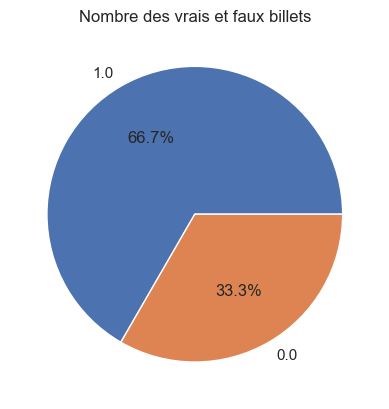

In [100]:
data=train_df['target'].value_counts()
labels=data.index
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Nombre des vrais et faux billets')
plt.show()

1=Vrais
0=faux

## 2.3 Nettoyage des données

In [101]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

target           0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

On a 37 valeurs manquantes dans la colonne margin_low

In [102]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% des données dans la colonne margin_low est manquantes. -> voir la distribution de cette variable

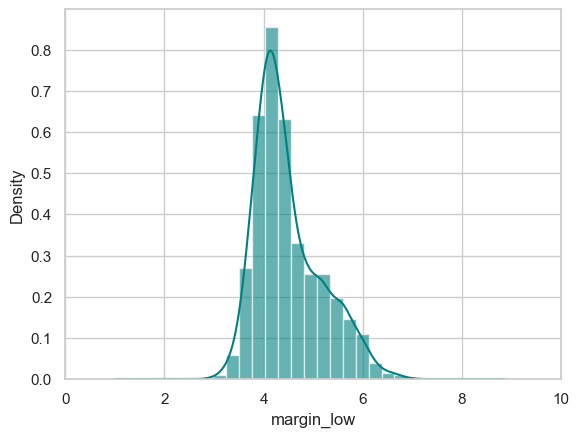

In [103]:
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

la mediane de margin_low est entre 4 et 5 mm.<br> On va essayer la regression lineaire pour l'imputation des valeurs manquantes.

### 2.3.1 Imputation des valeurs manquantes

In [104]:
train_df

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25


In [105]:
#Elimination de la target de notre DataFrame
#y=train_df['target']
#train_df.drop(columns='target', inplace=True)

On a un DataFrame qui contient X=6 (features)

## Imputation des valeurs manquantes

## les valeurs manquantes sont de type numerique

*** 1. La methode regression lineaire de sklearn ***

In [106]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test= train_df[train_df['margin_low'].isna()] #DataFrame qui contient que des valeurs manquantes dans la colonne margin_low

train = train_df[~train_df['margin_low'].isna()] #dataframe sans valeurs manquantes

In [107]:
test.shape

(37, 7)

In [108]:
train.shape

(1463, 7)

In [109]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#les variables explicative (X)
X_train = train.drop(columns=['margin_low', 'target']) 
X_train.head()

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54


In [110]:
# Création d'une instance de StandardScaler
scaler_1 = StandardScaler()
# Adapter le scaler aux données
scaler_1.fit(X_train)

# Standardiser les données
X_train_scaled = scaler_1.transform(X_train)
X_train_scaled[:5]

array([[-0.48859357,  2.76680735,  3.17376615, -1.13698239,  0.17784229],
       [-1.63480853, -2.24148961, -0.80685073, -0.7048056 ,  0.47569209],
       [ 2.39331832,  1.49803879, -1.30057066, -0.92089399,  0.55588243],
       [-1.96229852, -0.40511406,  0.05715913, -0.61837024,  0.95683409],
       [-0.75058556,  0.83026586, -1.42400064,  1.41286065, -0.15437481]])

In [111]:
#la variable cible (y) (target)
y_train= train['margin_low']
y_train.shape

(1463,)

In [112]:
# Initialiser les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Naive Model (median)': DummyRegressor(strategy='median'),
    'Naive Model (Mean)': DummyRegressor(strategy='mean')
}

# La validation croisée et les scores RMSE pour chaque modèle
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = (-scores) ** 0.5
    results[model_name] = {'mean_rmse': rmse_scores.mean(), 'std_rmse': rmse_scores.std()}

# Affichage des résultats
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print(f"Standard deviation of RMSE: {result['std_rmse']}\n")


Model: Linear Regression
Mean RMSE: 0.48164583801892363
Standard deviation of RMSE: 0.11550617228305025

Model: Naive Model (median)
Mean RMSE: 0.6822920177155671
Standard deviation of RMSE: 0.31702538904937455

Model: Naive Model (Mean)
Mean RMSE: 0.7213898563877186
Standard deviation of RMSE: 0.20682302212606174



Selon les métriques de RMSE (erreur), le modèle de régression linéaire démontre la meilleure performance parmi les trois modèles testés.

In [113]:
## Model_1: Régression linéaire
# Créer et entraîner le modèle de régression linéaire
model_1 = LinearRegression()
model_1.fit(X_train_scaled, y_train)

LinearRegression()

In [114]:
#creation de la variable X_test
X_test = test.drop(columns=['margin_low', 'target'])

In [115]:
X_test.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [116]:
# Standardisation des données de X_test
X_test_scaled = scaler_1.transform(X_test)
X_test_scaled[:5]

array([[-0.06285659, -0.47189135, -1.45485813,  0.41885404,  0.13201924],
       [-0.09560559,  0.12910429,  0.79773902, -0.05654042,  0.46423633],
       [ 0.3628804 , -0.77238917,  1.41488892, -0.57515256,  0.2923999 ],
       [-1.66755753, -1.23983022, -0.3748458 ,  2.01790815,  0.68189581],
       [-0.42309557,  0.36282481,  0.42744908, -0.57515256, -0.36057852]])

In [117]:
# Prédire les valeurs manquantes
y_predicted = model_1.predict(X_test_scaled)

In [118]:
y_predicted.shape

(37,)

In [119]:
y_predicted

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [120]:
#Creation d'une copy de notre DataFrame
df_reg=train_df.copy()

In [121]:
# Remplacement des valeurs manquantes par les valeurs prédites
df_reg.loc[df_reg['margin_low'].isna(), 'margin_low'] = y_predicted

In [122]:
#Verification
df_reg.isnull().sum()

target          0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [123]:
# preview adjusted train data
df_reg.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


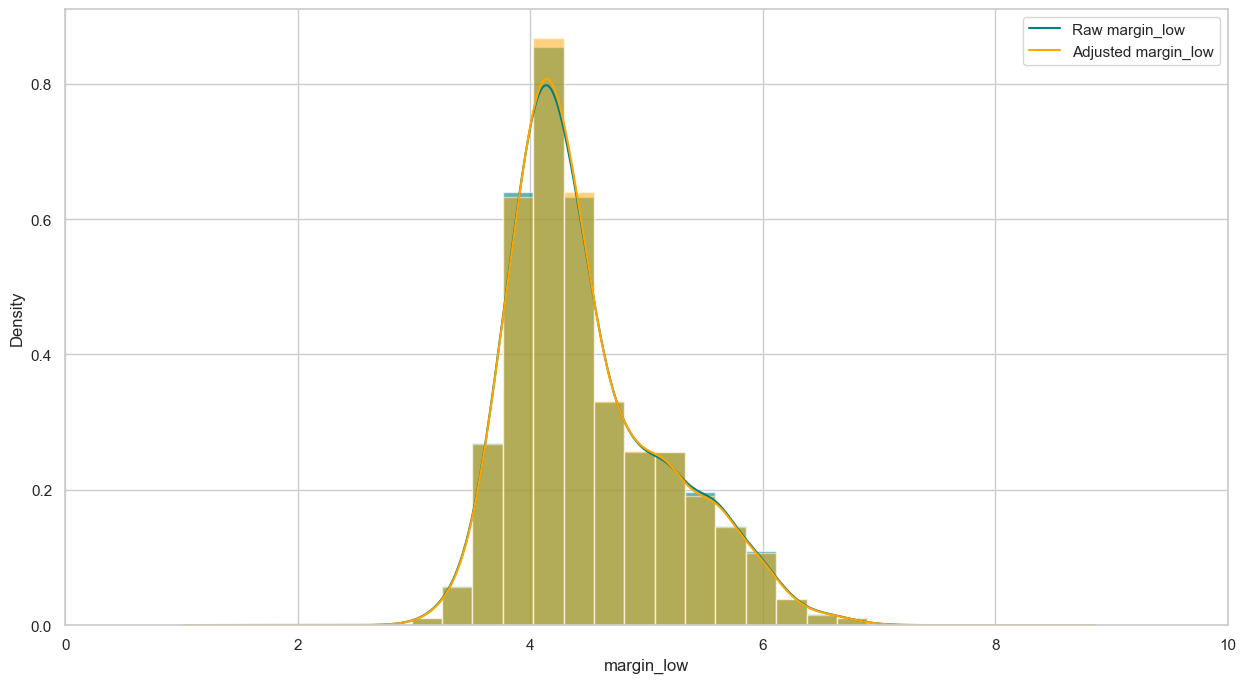

In [124]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_reg["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_reg["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

2. La méthode de régression linéaire de Statsmodels

In [125]:
# Créer et ajuster le modèle aux données d'entraînement
model_2 = sm.OLS(y_train, X_train_scaled)
model_fit = model_2.fit()

# Faire des prédictions sur les données de test mises à l'échelle
predicted_values = model_fit.predict(X_test_scaled)

# Afficher les valeurs prédites
print(predicted_values)

[-0.16744253 -0.09229964 -0.07551056 -0.16695296  0.16464991 -0.68265889
 -0.30623111 -0.35852565 -0.35093301 -0.32542868 -0.30854693 -0.71741341
 -0.42720334 -0.1879201  -0.32535973 -0.39190266 -0.04612093 -0.01531682
 -0.14432397 -0.40555271 -0.87166131 -0.11415572 -0.39234651 -0.23633823
 -0.5922189  -0.73963454 -0.24855238  0.22456568 -0.34818697  0.56430996
  0.31617803  0.58161681  0.56160248  0.29299998  1.24102581  0.69989494
  0.6540755 ]


In [126]:
#On a besoin d'une constante dans ce maodéle
X_train_scaled_with_const = sm.add_constant(X_train_scaled)
X_test_scaled_with_const = sm.add_constant(X_test_scaled)
X_test_scaled_with_const[:5]

array([[ 1.        , -0.06285659, -0.47189135, -1.45485813,  0.41885404,
         0.13201924],
       [ 1.        , -0.09560559,  0.12910429,  0.79773902, -0.05654042,
         0.46423633],
       [ 1.        ,  0.3628804 , -0.77238917,  1.41488892, -0.57515256,
         0.2923999 ],
       [ 1.        , -1.66755753, -1.23983022, -0.3748458 ,  2.01790815,
         0.68189581],
       [ 1.        , -0.42309557,  0.36282481,  0.42744908, -0.57515256,
        -0.36057852]])

In [127]:
model_2 = sm.OLS(y_train, X_train_scaled_with_const).fit()

In [128]:
model_2.params

const    4.485967
x1      -0.033912
x2       0.055145
x3       0.083331
x4       0.059278
x5      -0.357115
dtype: float64

In [129]:
y_train.mean()

4.485967190704033

In [130]:
predicted_values = model_2.predict(X_test_scaled_with_const)

In [131]:
predicted_values

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [132]:
df_stat=train_df.copy()

In [133]:
df_stat.loc[df_stat['margin_low'].isnull(), 'margin_low'] = predicted_values

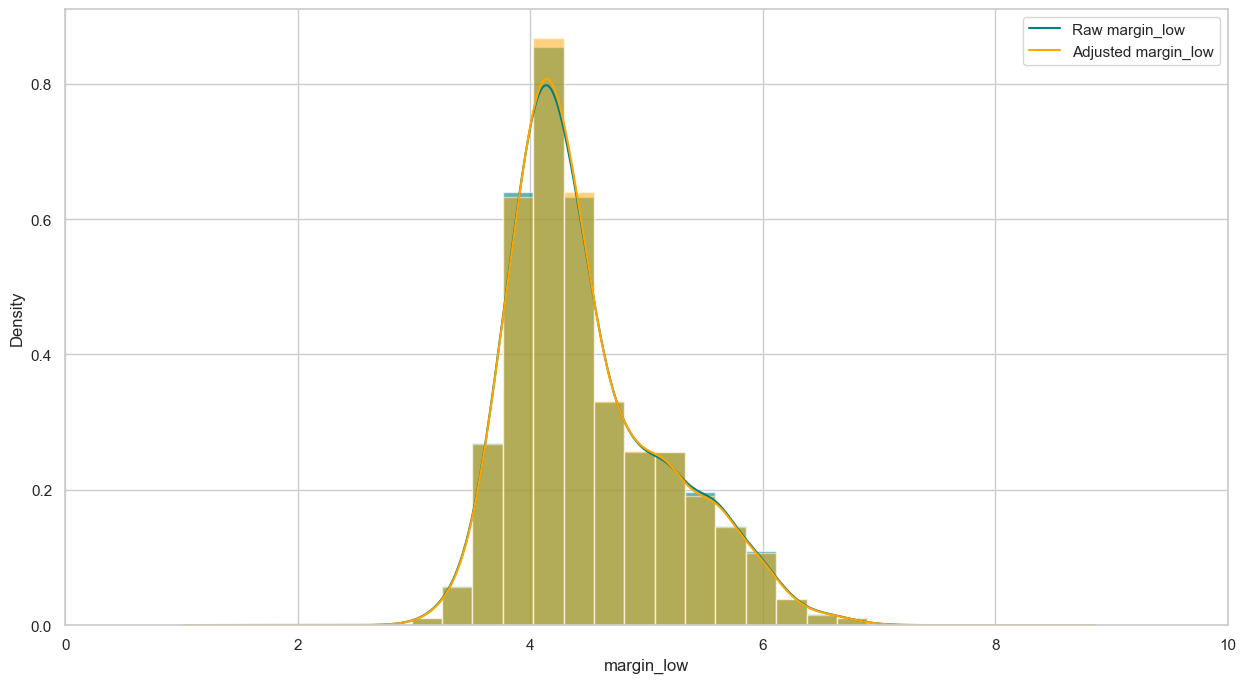

In [134]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_stat["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_stat["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

***Exploration des données***

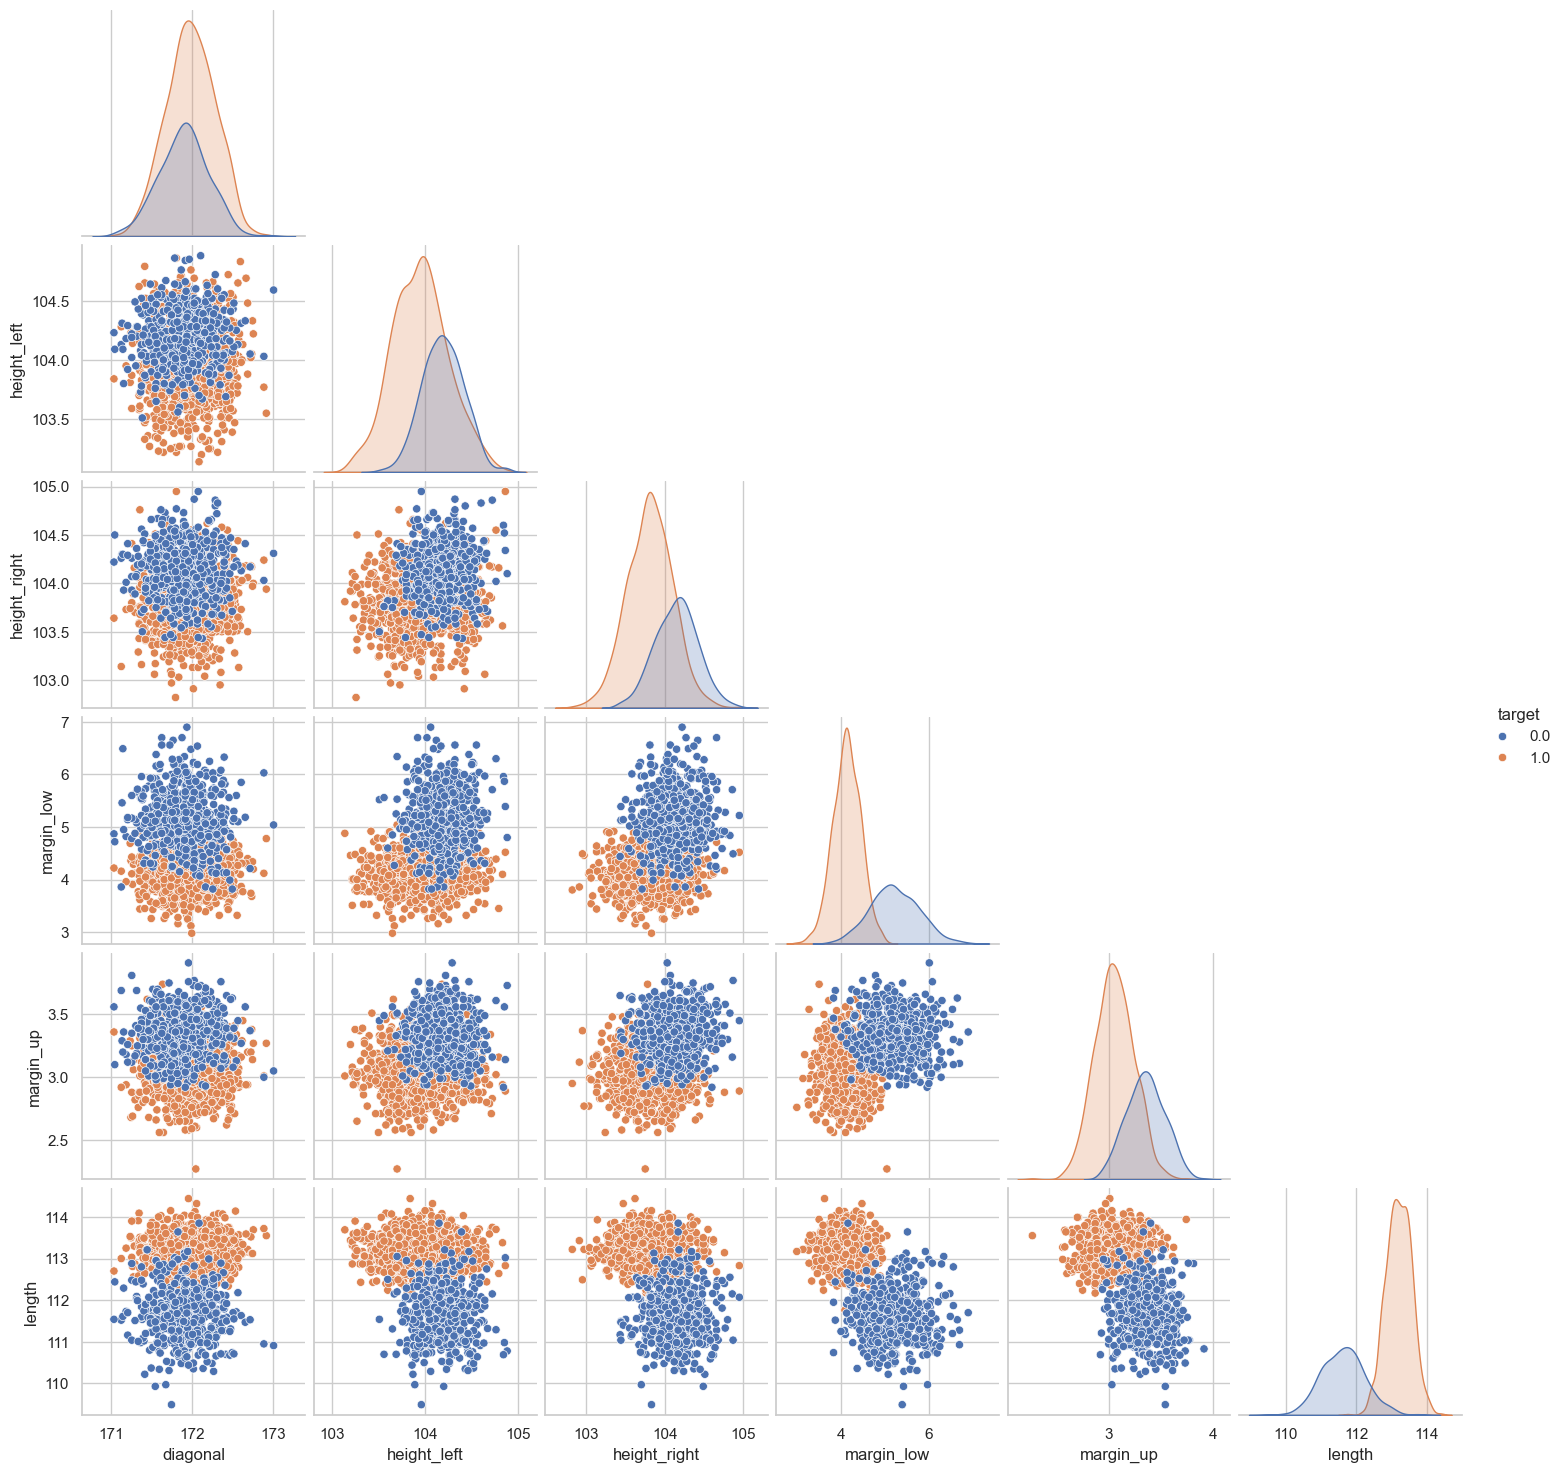

In [135]:
sns.pairplot(df_reg, hue='target', corner=True)
plt.show()

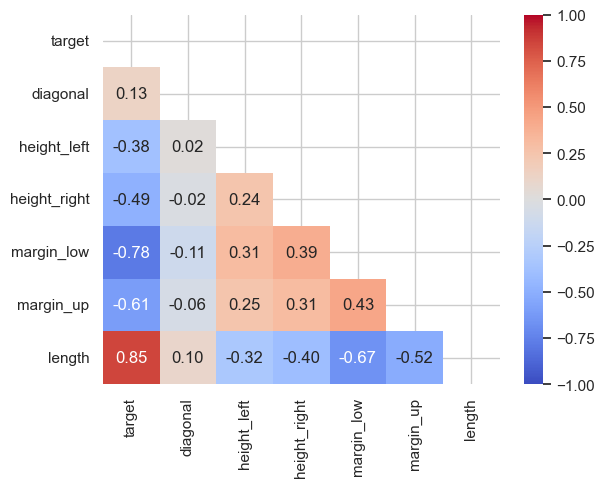

In [136]:
correlation_matrix = df_reg.corr()
masque=np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=masque, vmin=-1, vmax=1)
plt.show()

la target est tres correlée avec la longeur des billets

## 2.3.2 Detection des outliers

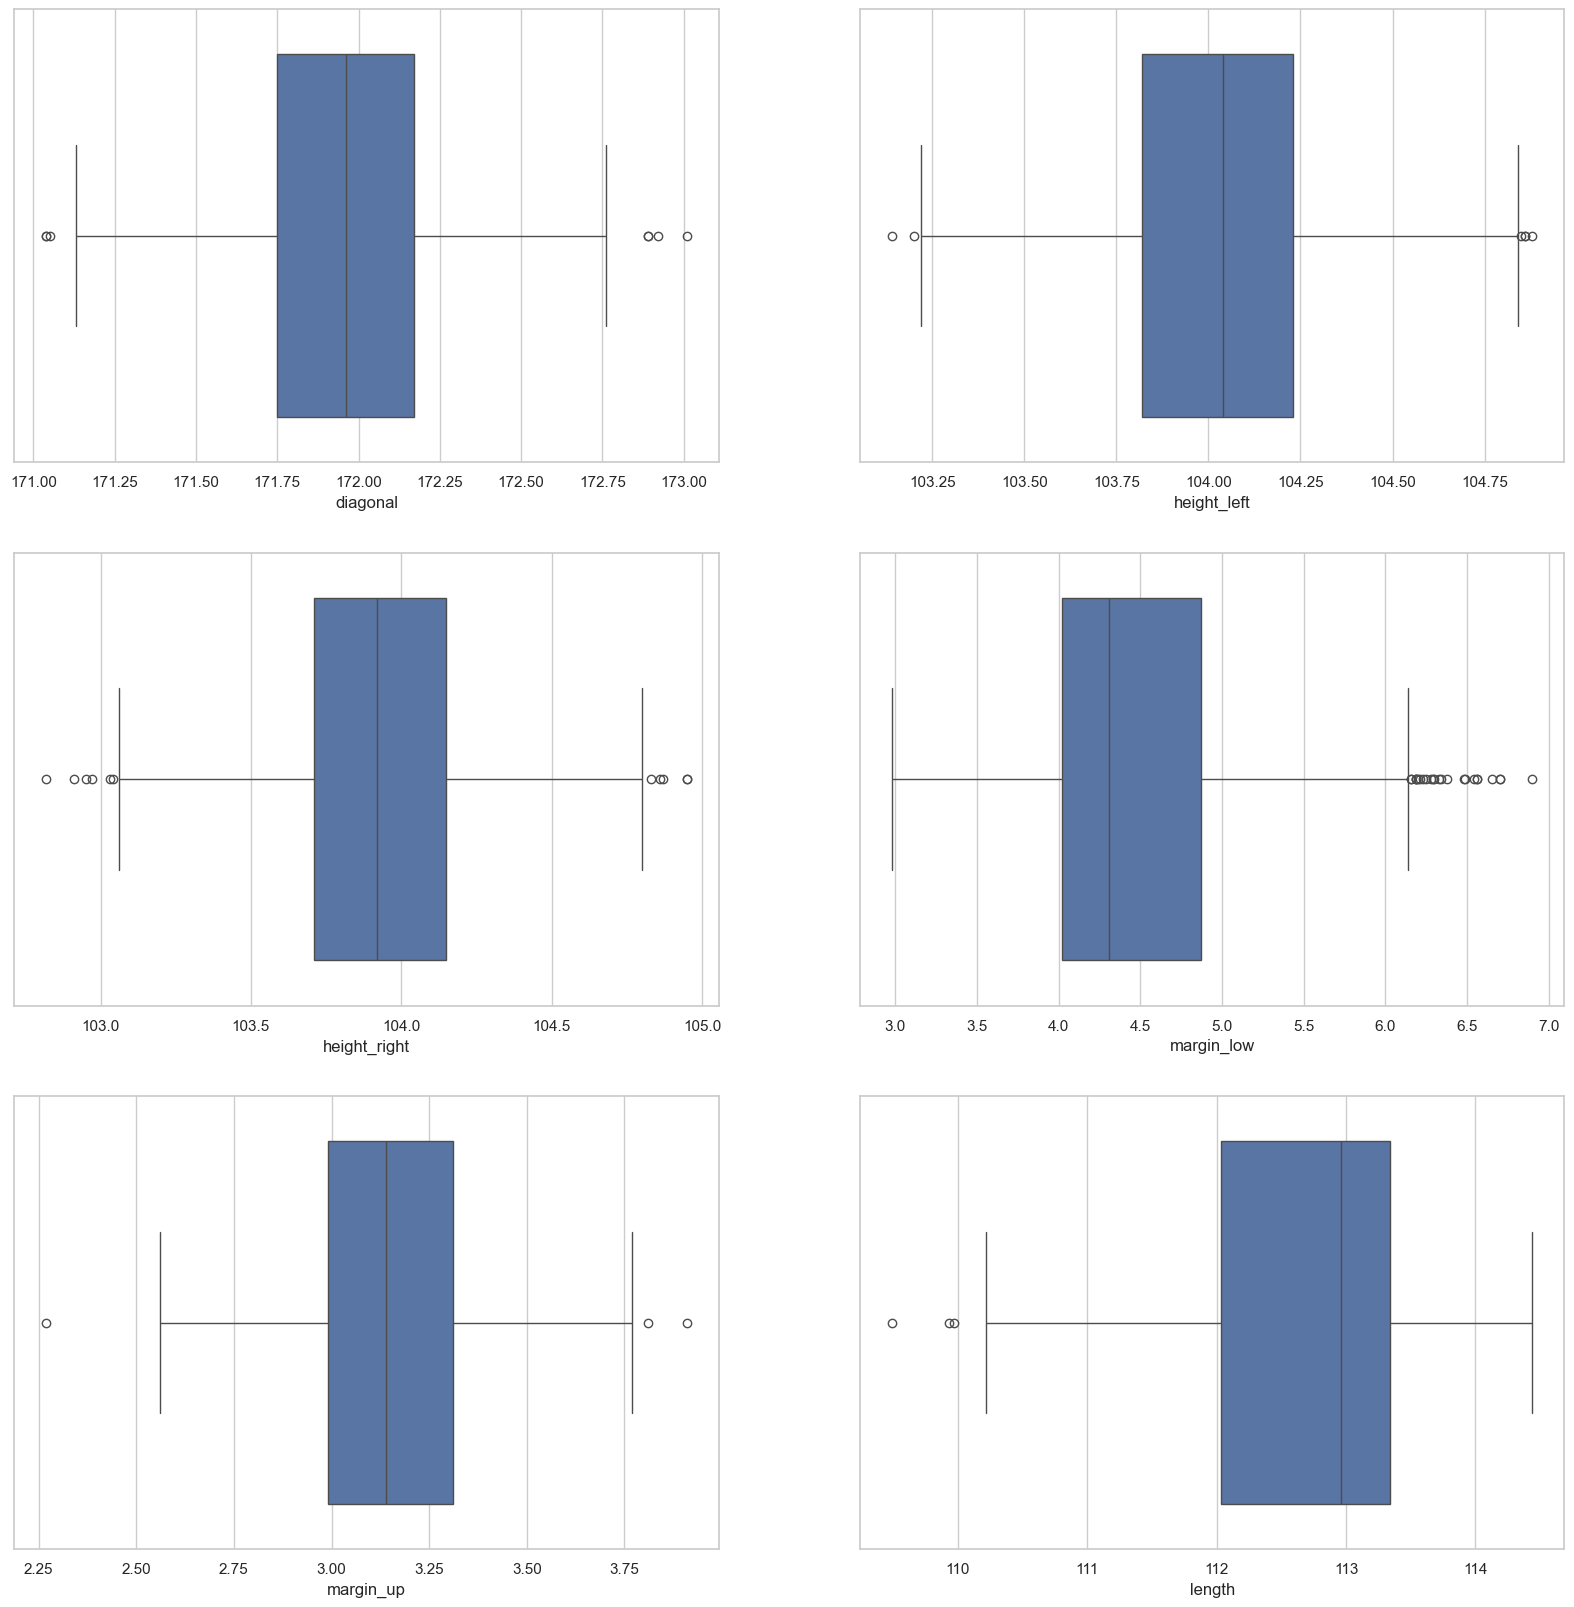

In [137]:
plt.figure(figsize=(20, 20))
sns.set_theme(style="whitegrid")

plt.subplot(321)
sns.boxplot(data=df_reg, x='diagonal')

plt.subplot(322)
sns.boxplot(data=df_reg, x='height_left')

plt.subplot(323)
sns.boxplot(data=df_reg, x='height_right')

plt.subplot(324)
sns.boxplot(data=df_reg, x='margin_low')

plt.subplot(325)
sns.boxplot(data=df_reg, x='margin_up')

plt.subplot(326)
sns.boxplot(data=df_reg, x='length')

plt.show()

Les boxplots montrent des outliers dans plusieurs features. Ceci peut indiquer que ces outliers pourraient être associés aux faux billets qui se distinguent par leurs dimensions non conformes

## 2.3.1.1 Data mining

## 2.4 Preparation des données

## Choix du modéle

Type de données categorielle


In [138]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        1500 non-null   float64
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(7)
memory usage: 82.2 KB


In [139]:
X=df_reg.drop(columns=['target'])
y=df_reg['target']

In [140]:
scaler_1.fit(X)
# Standardisation des données de X_test

X_scaled = scaler_1.transform(X)
X_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.0553898 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08198744, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12659056, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.30946288, -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67253163,  1.41767746,
        -0.15875038]])

In [141]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y= train_test_split(X, y, test_size=0.3, random_state=42)

In [142]:
#Application de la validation croisée afin de choisir le modèle le plus performant
# Initialiser les modèles
models = {
    'Naive Model (The most frequent)': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': SVC(kernel='linear')
}

# La validation croisée et les scores RMSE pour chaque modèle
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, train_X, train_y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = (-scores) ** 0.5
    results[model_name] = {'mean_rmse': rmse_scores.mean(), 'std_rmse': rmse_scores.std()}

# Affichage des résultats
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print(f"Standard deviation of RMSE: {result['std_rmse']}\n")

Model: Naive Model (The most frequent)
Mean RMSE: 0.5682027111418463
Standard deviation of RMSE: 0.0016798536240905993

Model: Logistic Regression
Mean RMSE: 0.10503302920588138
Standard deviation of RMSE: 0.01991567735247537

Model: Linear SVM
Mean RMSE: 0.10064645847816416
Standard deviation of RMSE: 0.01861399666900299



2.5 Modelisation

2.5.1 Dummy clussifier

In [143]:
estimator_1= DummyClassifier(strategy="most_frequent")
estimator_1.fit(train_X, train_y)

DummyClassifier(strategy='most_frequent')

In [144]:
y_pred_1 = estimator_1.predict(test_X)
y_pred_1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [145]:
pd.Series(y_pred_1).value_counts()

1.0    450
Name: count, dtype: int64

In [146]:
test_y.value_counts(normalize=True)

target
1.0    0.642222
0.0    0.357778
Name: proportion, dtype: float64

In [147]:
test_y.value_counts()

target
1.0    289
0.0    161
Name: count, dtype: int64

In [148]:
test_y.values

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1.

In [149]:
train_y

485     1.0
527     1.0
199     1.0
889     1.0
844     1.0
       ... 
1130    0.0
1294    0.0
860     1.0
1459    0.0
1126    0.0
Name: target, Length: 1050, dtype: float64

In [150]:
train_X

,diagonal,height_left,height_right,margin_low,margin_up,length
485,171.83,104.29,103.58,4.000000,3.32,113.21
527,171.92,103.79,103.34,3.840000,2.80,113.00
199,171.90,104.42,104.02,4.380000,3.10,112.87
889,172.31,103.94,103.89,4.000000,3.20,113.80
844,171.62,104.14,104.49,4.371811,2.99,113.35
...,...,...,...,...,...,...
1130,171.56,104.29,104.19,5.230000,3.63,112.94
1294,172.40,104.27,104.18,4.920000,3.17,111.79
860,171.38,103.83,103.99,4.440000,3.12,113.48
1459,171.78,104.31,103.82,6.190000,3.25,111.14


In [151]:
tr_score= estimator_1.score(train_X, train_y)
te_score= estimator_1.score(test_X, test_y)
print(f"le score de train est {tr_score}, et de test est {te_score}")

le score de train est 0.6771428571428572, et de test est 0.6422222222222222


In [161]:
y_pred_1 = estimator_1.predict(test_X)
y_pred_1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [153]:
test_y.values

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1.

In [162]:
1 - abs(y_pred_1 - test_y.values).mean()

0.6422222222222222

In [156]:
mat=confusion_matrix(test_y, y_pred_1, labels=estimator_1.classes_)
mat

array([[  0, 161],
       [  0, 289]], dtype=int64)

In [157]:
test_y.value_counts()

target
1.0    289
0.0    161
Name: count, dtype: int64

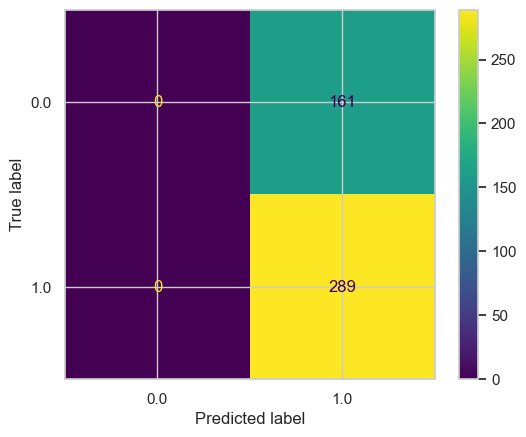

In [158]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels= estimator_1.classes_)
disp.plot()
plt.show()

161 des billets (faux billets) ont ete mal classés

## 2. Regression logistique

In [159]:
estimator_2 = LogisticRegression(solver='liblinear') #small dataset

In [160]:
estimator_2.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [165]:
y_pred_2=estimator_2.predict(test_X)
y_pred_2[:5]

array([0., 0., 1., 1., 1.])

In [166]:
test_y

1116    0.0
1368    0.0
422     1.0
413     1.0
451     1.0
       ... 
1083    0.0
990     1.0
650     1.0
1188    0.0
1498    0.0
Name: target, Length: 450, dtype: float64